In [1]:
# Loading necessary packages 
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples

import warnings
warnings.filterwarnings('ignore')

sns.set(context="talk", style="whitegrid", palette="Spectral", font="Verdana")

In [2]:
file_path = 'C:/Users/sogor/OneDrive/Documents/DataScientist_practice/datasets/Mall_Customers.csv'
df = pd.read_csv(file_path)

In [3]:
df

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0             1    Male   19                  15                      39
1             2    Male   21                  15                      81
2             3  Female   20                  16                       6
3             4  Female   23                  16                      77
4             5  Female   31                  17                      40
..          ...     ...  ...                 ...                     ...
195         196  Female   35                 120                      79
196         197  Female   45                 126                      28
197         198    Male   32                 126                      74
198         199    Male   32                 137                      18
199         200    Male   30                 137                      83

[200 rows x 5 columns]

**Problem statement**:
My goal is to understand customer behavior by identifying the most important shopping groups based on income, age, and spending score. I will try to divide the mall target into approachable groups, to better understand the target for marketing activities.

## Univariate Analysis
Univariate analysis is a type of data analysis that focuses on examining and describing the distribution of a single variable.

In [4]:
df.describe()

CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000

**Conclusion**:
- There are 200 customers in the dataset, as indicated by the count value for each variable, so we don't have missing values.
1. `Age`:
- The average age of customers is approximately 38.85 years.
- 25% of the customers are younger than 28.75 (~29) years, and 75% are younger than 49 years.
2. `Annual Income`:
- The average annual income of customers is 60.56k.
- The standard deviation is 26.26, showing significant variability in income levels.
3. `Spending Score`:
- The average spending score is 50.2, which is close to the midpoint of the scale.
- The spending score ranges from 1 to 99, indicating a wide range of spending behavior.

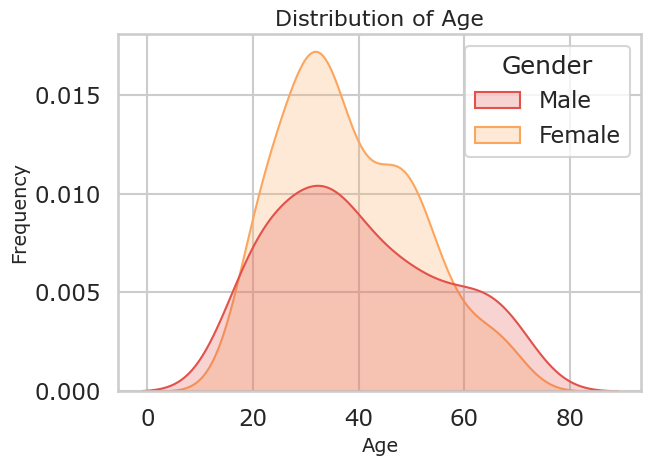

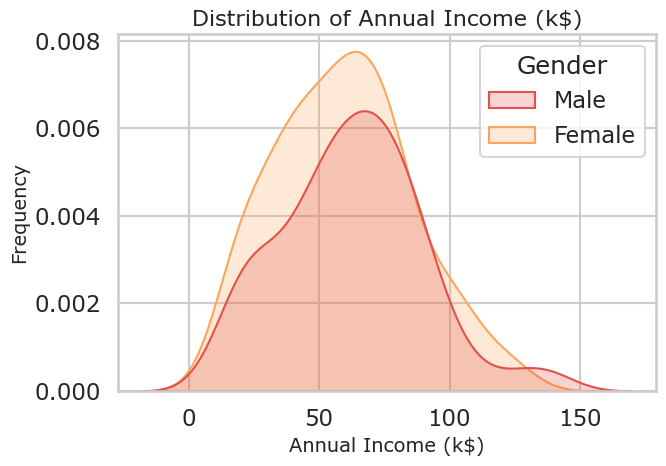

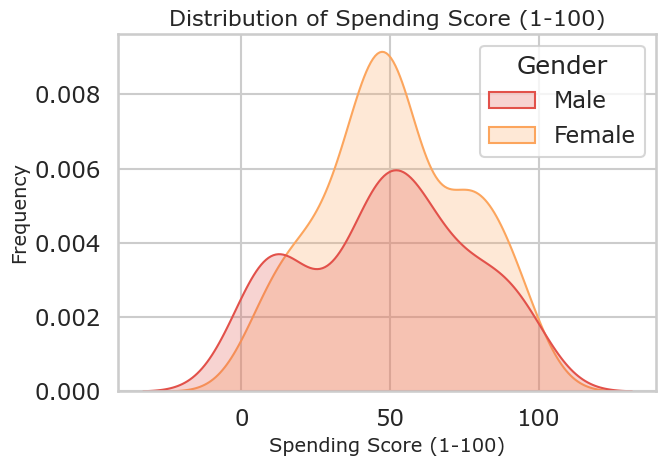

In [5]:
features_to_plot = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for item in features_to_plot:
    plt.figure(figsize=(7, 5))
    sns.kdeplot(x=item, shade=True, hue='Gender', data=df)
    plt.title(f'Distribution of {item}', fontsize=16)
    plt.xlabel(item, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.tight_layout()
    plt.show()

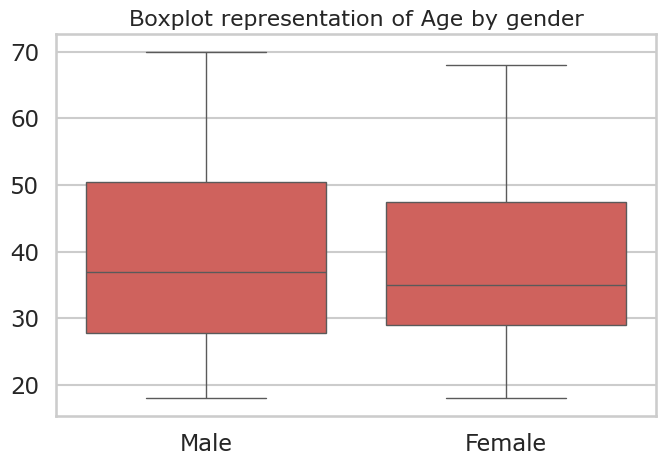

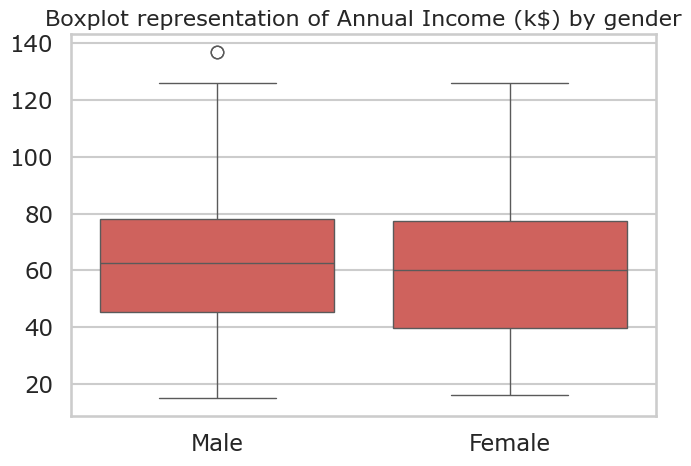

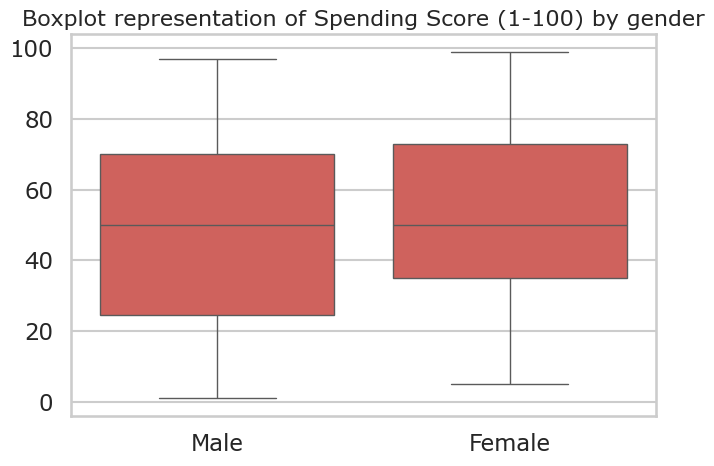

In [6]:
features_to_plot = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for item in features_to_plot:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x='Gender', y=item, data=df)
    plt.title(f'Boxplot representation of {item} by gender', fontsize=16)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

In [7]:
df['Gender'].value_counts(normalize=True)

Gender
Female    0.56
Male      0.44
Name: proportion, dtype: float64

As assumed the customer base at the mall is slightly skewed towards females, with females making up 56% of the total customers. Given the higher proportion of female customers, the company could consider tailoring its marketing strategies to appeal more to women. This could include targeted promotions, events, and product offerings that are more likely to attract and retain female shoppers. However, it is also important to develop strategies that appeal to the male segment, which constitutes a substantial 44% of the customer base.

## Bivariate Analysis 
Bivariate analysis is a statistical method used to examine the relationship between two variables.

In [8]:
# CustomerID will not influence our visualizations or add any value to my clusters, so I drop it
df2 = df.copy()
df2.drop('CustomerID', axis=1, inplace=True)

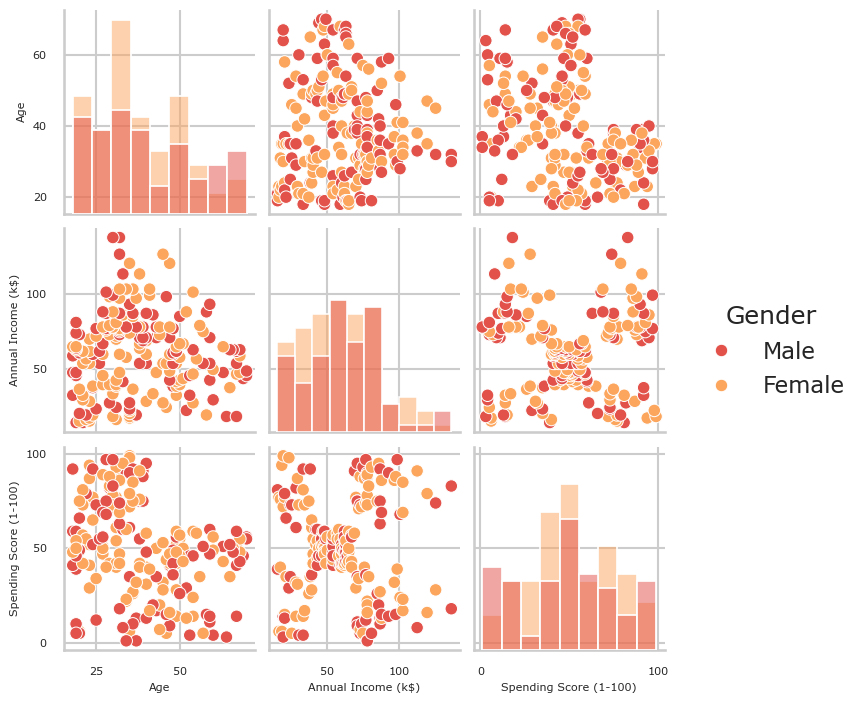

In [9]:
pair_plot = sns.pairplot(data=df2, hue='Gender', diag_kind="hist")

for ax in pair_plot.axes.flatten():
    if ax is not None:
        ax.set_xlabel(ax.get_xlabel(), fontsize=8)
        ax.set_ylabel(ax.get_ylabel(), fontsize=8)

        for label in ax.get_xticklabels():
            label.set_fontsize(8)
        
        for label in ax.get_yticklabels():
            label.set_fontsize(8)

plt.show()

In [10]:
# Statistical measures by gender

statistics = df.groupby('Gender')[features_to_plot].agg(['mean', 'min', 'max'])
statistics.columns = [' '.join(col).strip() for col in statistics.columns.values]

statistics

Age mean  Age min  Age max  Annual Income (k$) mean  \
Gender                                                         
Female  38.098214       18       68                59.250000   
Male    39.806818       18       70                62.227273   

        Annual Income (k$) min  Annual Income (k$) max  \
Gender                                                   
Female                      16                     126   
Male                        15                     137   

        Spending Score (1-100) mean  Spending Score (1-100) min  \
Gender                                                            
Female                    51.526786                           5   
Male                      48.511364                           1   

        Spending Score (1-100) max  
Gender                              
Female                          99  
Male                            97

# Clustering - Univariate, Bivariate, Multivariate 

**Metrics of clusterings**:
`Silhouette Score` assesses the quality of clustering by considering both cohesion (within-cluster compactness) and separation (between-cluster distance), while `WCSS` focuses on the compactness of the clusters.
**Difference and usage**:
- Silhouette Score:
    - Evaluates how well points are clustered with points in their own cluster and how well they are separated from points in other clusters.
    - Used for assessing the overall quality and appropriateness of the clustering.
    - Can be applied to various clustering algorithms.

- Within-Cluster Sum of Squares (WCSS):
    - Measures the compactness of clusters.
    - Primarily used with K-Means to determine the optimal number of clusters using the elbow method.
    - Lower WCSS values indicate more compact clusters.

### KMeans
K-Means is one of the most popular and straightforward clustering algorithms used in data analysis and machine learning. The primary goal of K-Means is to partition a dataset into KK distinct, non-overlapping clusters based on feature similarity. Each cluster is represented by its centroid, which is the mean of the points in that cluster. K-Means aims to minimize the within-cluster sum of squares (WCSS), also known as inertia.
**Algorithm Steps**:
- Initialization: Choose KK initial centroids randomly from the data points.
- Assignment: Assign each data point to the nearest centroid, forming KK clusters.
- Update: Calculate new centroids by computing the mean of all data points in each cluster.
- Iteration: Repeat the assignment and update steps until the centroids no longer change significantly or a maximum number of iterations is reached.

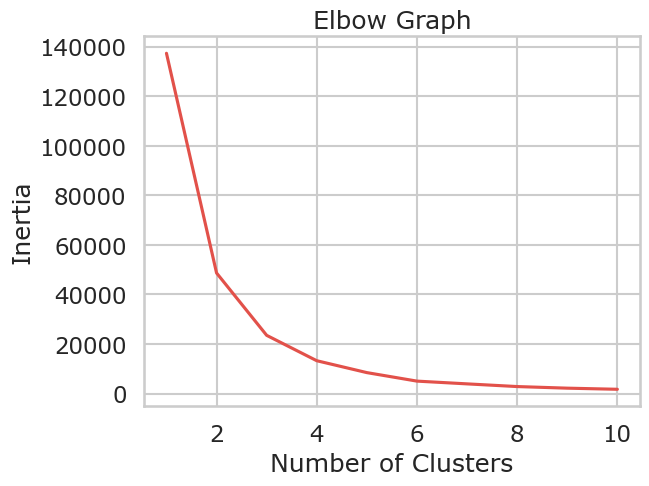

In [11]:
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(df[['Annual Income (k$)']])
    
    wcss.append(kmeans.inertia_)

plt.title('Elbow Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(range(1,11), wcss)
plt.show()

In [12]:
cluster_a = KMeans(n_clusters=3)

cluster_a.fit(df[['Annual Income (k$)']])

KMeans(n_clusters=3)

In [13]:
df['Income Cluster'] = cluster_a.labels_
df.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Income Cluster  
0               1  
1               1  
2               1  
3               1  
4               1

In [14]:
statistics2 = df.groupby('Income Cluster')[features_to_plot].agg(['mean', 'min', 'max'])
statistics2.columns = [' '.join(col).strip() for col in statistics2.columns.values]

statistics2

Age mean  Age min  Age max  Annual Income (k$) mean  \
Income Cluster                                                         
0               38.722222       18       68                67.088889   
1               39.500000       18       70                33.486486   
2               37.833333       27       59                99.888889   

                Annual Income (k$) min  Annual Income (k$) max  \
Income Cluster                                                   
0                                   54                      81   
1                                   15                      50   
2                                   85                     137   

                Spending Score (1-100) mean  Spending Score (1-100) min  \
Income Cluster                                                            
0                                 50.000000                           1   
1                                 50.229730                           3   
2                                 50.638889                           8   

                Spending Score (1-100) max  
Income Cluster                              
0                                       97  
1                                       99  
2                                       97

#### Segmentation by Annual Income and Spending Score.

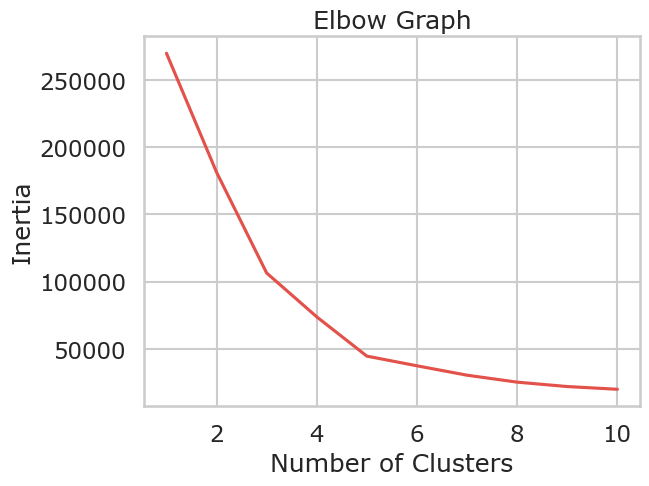

In [15]:
wcss2 = []

for i in range(1,11):
    kmeans2 = KMeans(n_clusters=i, init='k-means++')
    kmeans2.fit(df[['Annual Income (k$)', 'Spending Score (1-100)']])
    
    wcss2.append(kmeans2.inertia_)
    
plt.title('Elbow Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(range(1,11), wcss2)
plt.show()

In [16]:
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df[['Annual Income (k$)', 'Spending Score (1-100)']])
df[['Annual Income (k$)', 'Spending Score (1-100)']] = scaled_values

df

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0             1    Male   19           -1.738999               -0.434801   
1             2    Male   21           -1.738999                1.195704   
2             3  Female   20           -1.700830               -1.715913   
3             4  Female   23           -1.700830                1.040418   
4             5  Female   31           -1.662660               -0.395980   
..          ...     ...  ...                 ...                     ...   
195         196  Female   35            2.268791                1.118061   
196         197  Female   45            2.497807               -0.861839   
197         198    Male   32            2.497807                0.923953   
198         199    Male   32            2.917671               -1.250054   
199         200    Male   30            2.917671                1.273347   

     Income Cluster  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
..              ...  
195               2  
196               2  
197               2  
198               2  
199               2  

[200 rows x 6 columns]

In [17]:
cluster_b = KMeans(n_clusters=5)
cluster_b.fit(df[['Annual Income (k$)', 'Spending Score (1-100)']])

KMeans(n_clusters=5)

In [18]:
df['Spending & Income Cluster'] = cluster_b.labels_
df.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19           -1.738999               -0.434801   
1           2    Male   21           -1.738999                1.195704   
2           3  Female   20           -1.700830               -1.715913   
3           4  Female   23           -1.700830                1.040418   
4           5  Female   31           -1.662660               -0.395980   

   Income Cluster  Spending & Income Cluster  
0               1                          4  
1               1                          2  
2               1                          4  
3               1                          2  
4               1                          4

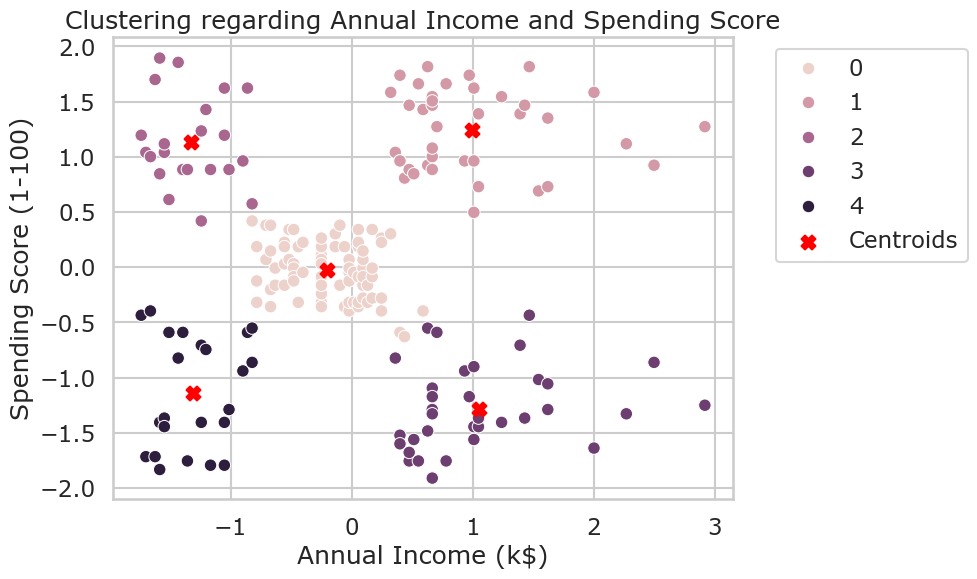

In [19]:
centroids = cluster_b.cluster_centers_

plt.figure(figsize=(8,6))

sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Spending & Income Cluster')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=100, c='red', label='Centroids')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Clustering regarding Annual Income and Spending Score')
plt.show()

In [20]:
# Distribution of gender in Spending & Income clusters
pd.crosstab(df['Spending & Income Cluster'], df['Gender'], normalize='index')

Gender                       Female      Male
Spending & Income Cluster                    
0                          0.592593  0.407407
1                          0.538462  0.461538
2                          0.590909  0.409091
3                          0.457143  0.542857
4                          0.608696  0.391304

In [21]:
df.groupby('Spending & Income Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()

Age  Annual Income (k$)  \
Spending & Income Cluster                                  
0                          42.716049           -0.200913   
1                          32.692308            0.991583   
2                          25.272727           -1.329545   
3                          41.114286            1.055003   
4                          45.217391           -1.307519   

                           Spending Score (1-100)  
Spending & Income Cluster                          
0                                       -0.026456  
1                                        1.239503  
2                                        1.132178  
3                                       -1.284439  
4                                       -1.136965

#### Segmentation by Age and Spending Score 

In [22]:
scaled_age = scaler.fit_transform(df[['Age']])
df[['Age']] = scaled_age

df  

CustomerID  Gender       Age  Annual Income (k$)  Spending Score (1-100)  \
0             1    Male -1.424569           -1.738999               -0.434801   
1             2    Male -1.281035           -1.738999                1.195704   
2             3  Female -1.352802           -1.700830               -1.715913   
3             4  Female -1.137502           -1.700830                1.040418   
4             5  Female -0.563369           -1.662660               -0.395980   
..          ...     ...       ...                 ...                     ...   
195         196  Female -0.276302            2.268791                1.118061   
196         197  Female  0.441365            2.497807               -0.861839   
197         198    Male -0.491602            2.497807                0.923953   
198         199    Male -0.491602            2.917671               -1.250054   
199         200    Male -0.635135            2.917671                1.273347   

     Income Cluster  Spending & Income Cluster  
0                 1                          4  
1                 1                          2  
2                 1                          4  
3                 1                          2  
4                 1                          4  
..              ...                        ...  
195               2                          1  
196               2                          3  
197               2                          1  
198               2                          3  
199               2                          1  

[200 rows x 7 columns]

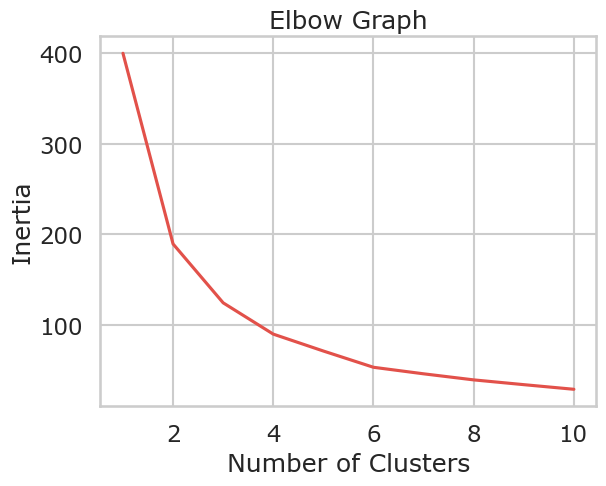

In [23]:
features = df[['Age', 'Spending Score (1-100)']].iloc[: , :].values
wcss3 = []

for i in range(1 , 11):
    kmeans3 = KMeans(n_clusters = i, init='k-means++')
    kmeans3.fit(features)
    
    wcss3.append(kmeans3.inertia_)
    
plt.title('Elbow Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(range(1,11), wcss3)
plt.show()

In [24]:
cluster_c = KMeans(n_clusters=3)
cluster_c.fit(df[['Age', 'Spending Score (1-100)']])

KMeans(n_clusters=3)

In [25]:
df['Age & Spending Cluster'] = cluster_c.labels_
df.head() 

CustomerID  Gender       Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male -1.424569           -1.738999               -0.434801   
1           2    Male -1.281035           -1.738999                1.195704   
2           3  Female -1.352802           -1.700830               -1.715913   
3           4  Female -1.137502           -1.700830                1.040418   
4           5  Female -0.563369           -1.662660               -0.395980   

   Income Cluster  Spending & Income Cluster  Age & Spending Cluster  
0               1                          4                       2  
1               1                          2                       1  
2               1                          4                       2  
3               1                          2                       1  
4               1                          4                       2

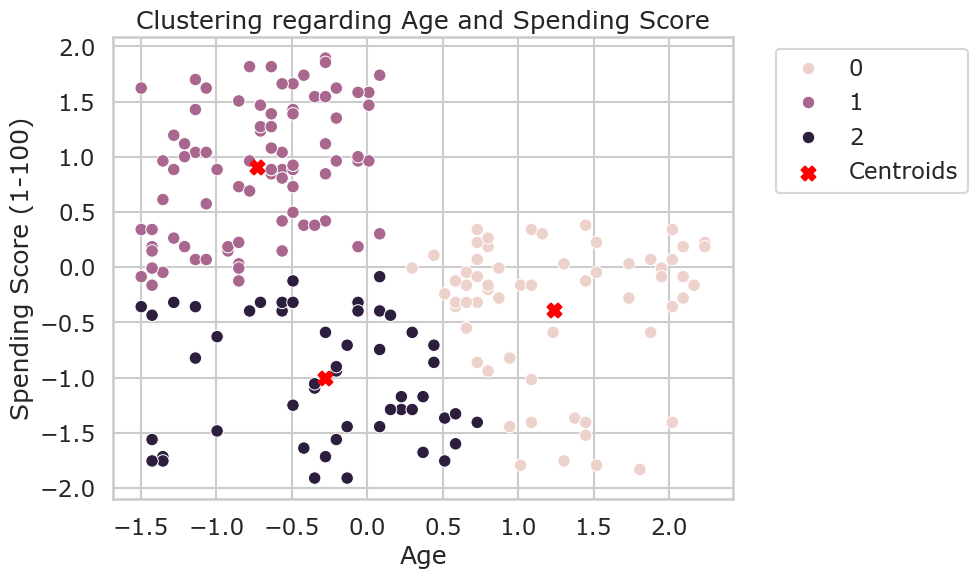

In [26]:
centroids2 = cluster_c.cluster_centers_

plt.figure(figsize=(8,6))

sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)', hue='Age & Spending Cluster')
plt.scatter(centroids2[:, 0], centroids2[:, 1], marker='X', s=100, c='red', label='Centroids')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Clustering regarding Age and Spending Score')
plt.show()

#### Segmentation by Age, Income and Spending Score 

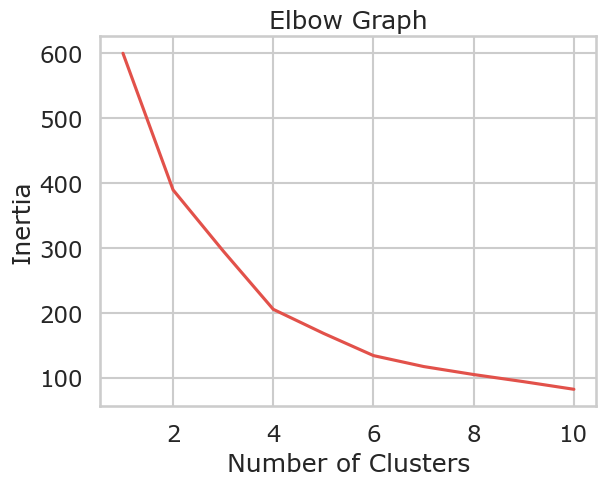

In [27]:
features2 = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].iloc[: , :].values
wcss4 = []

for i in range(1 , 11):
    kmeans4 = KMeans(n_clusters = i, init='k-means++')
    kmeans4.fit(features2)
    
    wcss4.append(kmeans4.inertia_)
    
plt.title('Elbow Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(range(1,11), wcss4)
plt.show()

In [28]:
cluster_d = KMeans(n_clusters=4)
cluster_d.fit(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

KMeans(n_clusters=4)

In [29]:
labels = cluster_d.labels_
df['Age-Income-Spending Cluster'] = labels
centroids = cluster_d.cluster_centers_

In [30]:
unique_clusters = df['Age-Income-Spending Cluster'].unique()

traces = []

for cluster_label in unique_clusters:
    cluster_data = df[df['Age-Income-Spending Cluster'] == cluster_label]
    trace = go.Scatter3d(
        x=cluster_data['Age'],
        y=cluster_data['Spending Score (1-100)'],
        z=cluster_data['Annual Income (k$)'],
        mode='markers',
        marker=dict(
            color=cluster_label,
            size=20,
            line=dict(
                color=cluster_label,
                width=12
            ),
            opacity=0.8
        ),
        name=f'Cluster {cluster_label}' 
    )
    traces.append(trace)

layout = go.Layout(
    title='Multivariate clustering regarding Age, Income, and Spending Score',
    scene=dict(
        xaxis=dict(title='Age'),
        yaxis=dict(title='Spending Score'),
        zaxis=dict(title='Annual Income')
    )
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

### DBSCAN 
DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. This technique is one of the most common clustering algorithms which works based on density of object. The whole idea is that if a particular point belongs to a cluster, it should be near to lots of other points in that cluster.

It works based on two parameters: *Epsilon and MinPts*
1. `Epsilon` determine a specified radius that if includes enough number of points within, we call it dense area.
2. `minimum-points` determine the minimum number of data points we want in a neighborhood to define a cluster.

In [31]:
eps_values = np.arange(0.1, 1.5, 0.1)
min_samples_values = range(2, 10)

best_score = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df[['Annual Income (k$)', 'Spending Score (1-100)']])
        
        if len(set(labels)) <= 2:
            continue
        
        score = silhouette_score(df[['Annual Income (k$)', 'Spending Score (1-100)']], labels)
        
        if score > best_score:
            best_score = score
            best_params = (eps, min_samples)

best_eps, best_min_samples = best_params
print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_score}")

Best eps: 0.4, Best min_samples: 8, Best Silhouette Score: 0.4148124800517594


In [32]:
dbscan = DBSCAN(eps=0.4, min_samples=8)

cluster_c = dbscan.fit(df[['Annual Income (k$)', 'Spending Score (1-100)']])

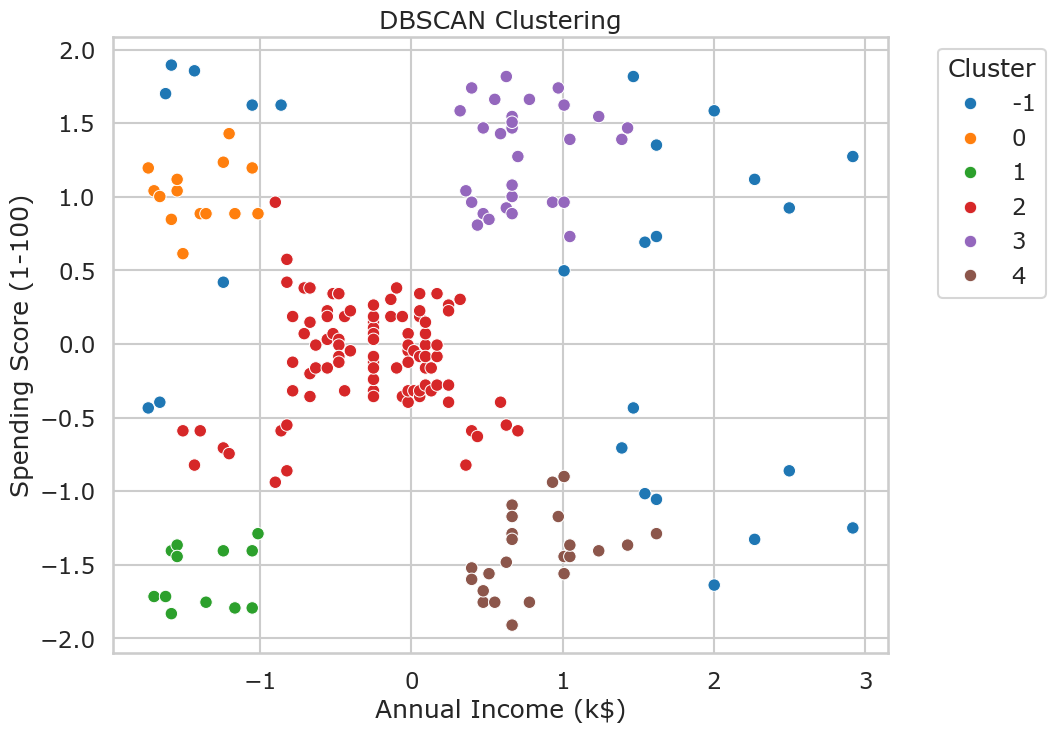

In [33]:
df['DBSCAN_Cluster'] = cluster_c.labels_

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='DBSCAN_Cluster', palette='tab10')
plt.title('DBSCAN Clustering')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster')
plt.show()

As we can observe DBSCAN doesn't perform very well because the density in our data is not that strong. Label -1 represents outliers so it will appear most as outliers. We may have performed better if we had had a larger data. 

### Hierarchical Clustering 
`Hierarchical clustering` is a method of cluster analysis that seeks to build a hierarchy of clusters. It is commonly represented as a tree-like diagram known as a dendrogram.
There are two main types of hierarchical clustering: `agglomerative (bottom-up) and divisive (top-down)`.
- `Agglomerative clustering`, a type of hierarchical clustering, starts with each data point as its own cluster and iteratively merges the closest pairs of clusters until a single cluster remains or a stopping criterion is met.
Common linkage methods include single linkage, `Complete Linkage, Average Linkage, and Ward's method`.
- `Ward's method` it is known for its ability to create clusters that minimize the variance within each cluster, often resulting in compact and well-separated clusters.

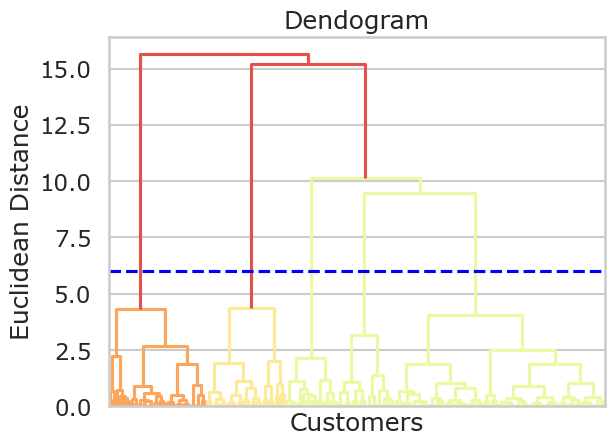

In [34]:
import scipy.cluster.hierarchy as sch

X = df.iloc[:, 3:5].values

dendogram = sch.dendrogram(sch.linkage(X, method='ward', metric='euclidean'), no_labels=True)

plt.title('Dendogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.axhline(y=6, color='blue', linestyle='--')
plt.show()

In [35]:
from sklearn.cluster import AgglomerativeClustering
agg_hc = AgglomerativeClustering(n_clusters=5)
agg_hc.fit(X)

AgglomerativeClustering(n_clusters=5)

In [36]:
agg_hc.labels_

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 2,
       4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 0, 1, 0, 1,
       2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1], dtype=int64)

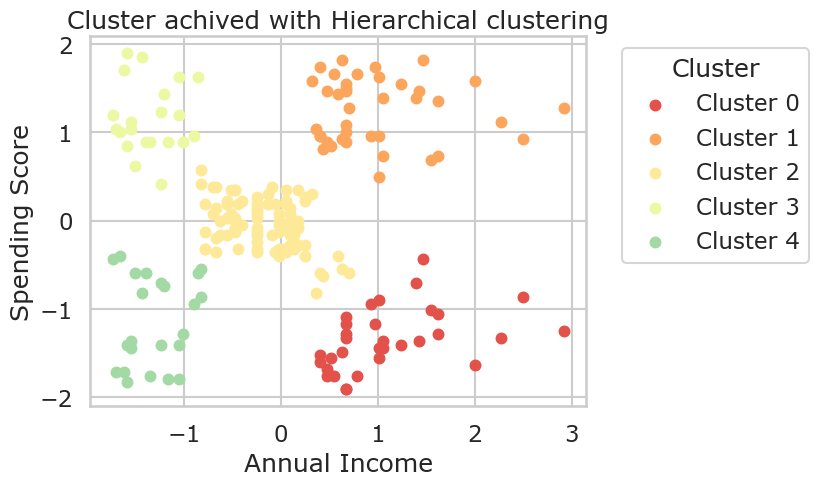

In [37]:
for i in range(agg_hc.n_clusters_):
    plt.scatter(X[agg_hc.labels_ == i, 0], X[agg_hc.labels_ == i, 1], s=50, label='Cluster ' + str(i)) 
    

plt.title('Cluster achived with Hierarchical clustering')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster')
plt.show()

## Silhouette plot

For n_clusters=2, the average silhouette_score is : 0.33547192894004574


For n_clusters=3, the average silhouette_score is : 0.3579234303882264


For n_clusters=4, the average silhouette_score is : 0.4039582785148566


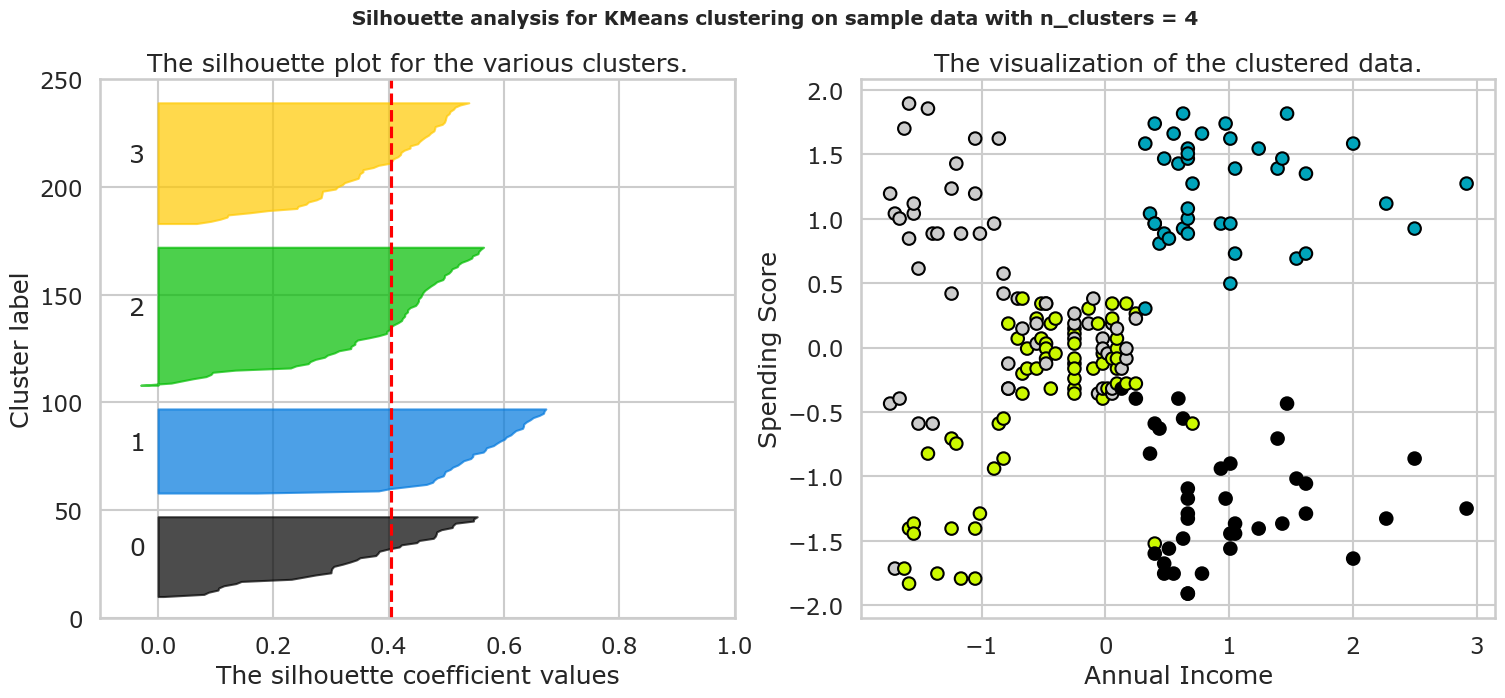

For n_clusters=5, the average silhouette_score is : 0.41664341513732767


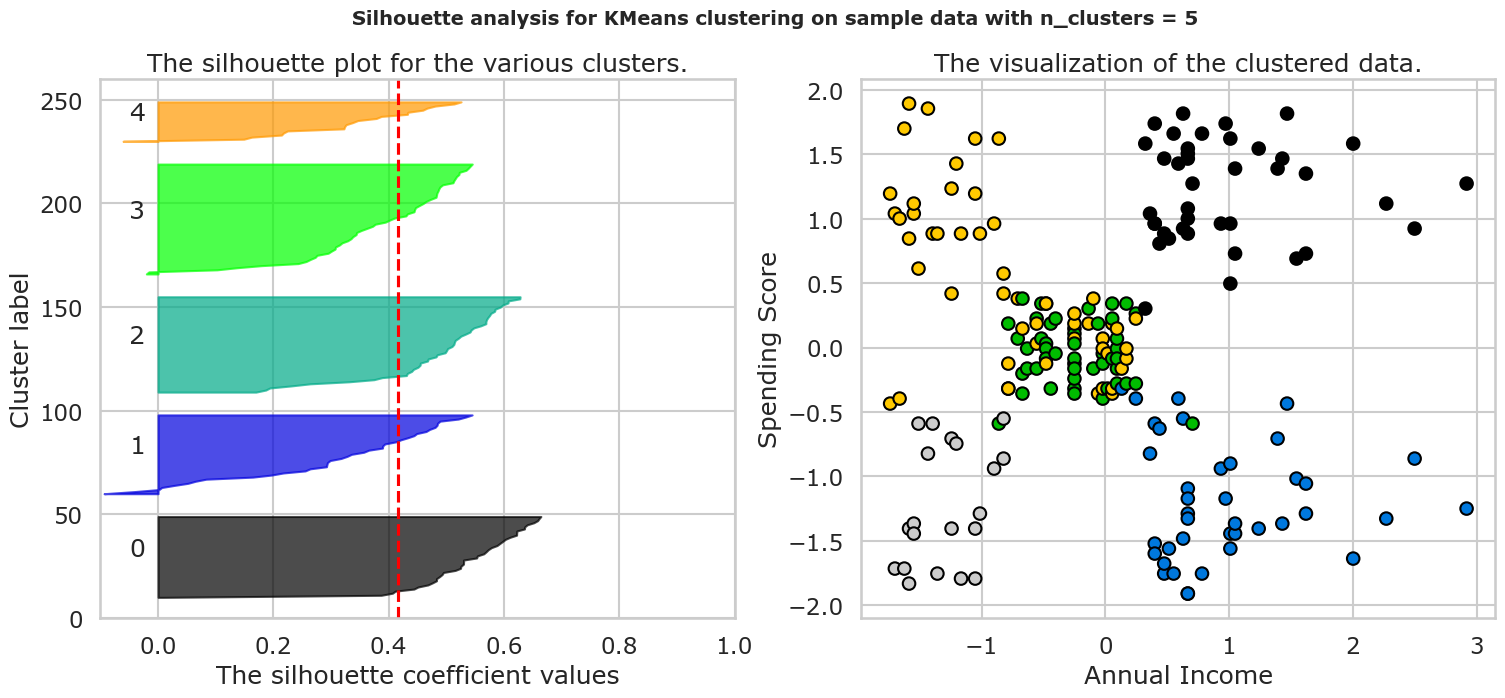

For n_clusters=6, the average silhouette_score is : 0.43106526216603014


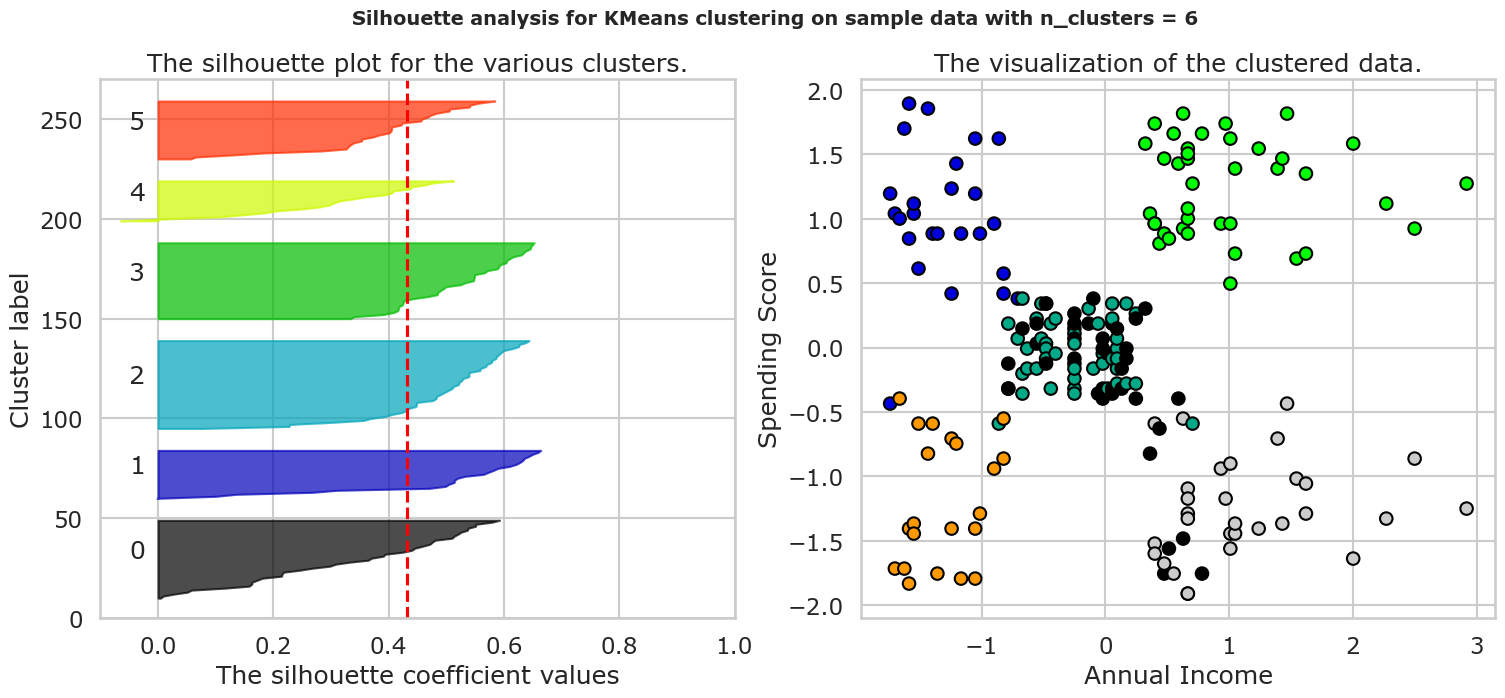

In [38]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

    silhouette_avg = silhouette_score(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], cluster_labels)
    print(f"For n_clusters={n_clusters}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax2.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], c=cluster_labels, cmap=cm.nipy_spectral, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Annual Income")
    ax2.set_ylabel("Spending Score")

    plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}", fontsize=14, fontweight='bold')
    plt.show()